In [1]:
import os
import numpy as np
import torch
import pickle
import time
import sys

current_directory = os.getcwd()
models_dir = os.path.join(current_directory, '..')
print(models_dir)
sys.path.append(models_dir)

import torch
from torch.utils.data import DataLoader, Dataset
from models import Pose2AudioTransformer
from transformers import EncodecModel
from utils import DanceToMusic
from datetime import datetime
from torch.optim import Adam

/home/azeez/Documents/projects/DanceToMusicApp/ml/notebooks/..


/home/azeez/anaconda3/envs/dance2music/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_rate = 24000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "facebook/encodec_24khz"
encodec_model = EncodecModel.from_pretrained(model_id)
encodec_model.to(device)

data_dir = "/Users/azeez/Documents/pose_estimation/DanceToMusicApp/ml/data/samples/3sec_24fps_dnb"
data_dir = "/home/azeez/Documents/projects/DanceToMusicApp/ml/data/samples/3sec_24fps_dnb"
dataset = DanceToMusic(data_dir, encoder = encodec_model, sample_rate = sample_rate, device=device)

/home/azeez/anaconda3/envs/dance2music/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
dataset_filtered = DanceToMusic(data_dir, encoder = encodec_model, sample_rate = sample_rate, device=device, clean_poses=True, 
                                movement_threshold= 0.09, keypoints_threshold = 3, frame_threshold = 0.1)
print(f"Length of dataset: {len(dataset)} and length after filtering: {len(dataset_filtered)}")

Length of dataset: 1705 and length after filtering: 1002


In [48]:
def calculate_movement(kp1, kp2):
    return np.linalg.norm(kp1 - kp2, axis=1)

def keypoint_stability_check(data, movement_threshold, keypoints_threshold):
    # data is a numpy array of shape [n, 32, 3]
    error_frames = []
    for i in range(1, len(data)):
        # Calculate movement for each keypoint from frame i-1 to i
        movement = calculate_movement(data[i-1, :, :2], data[i, :, :2])
        
        # Identify occluded keypoints (assuming they are marked as NaN)
        occluded = np.isnan(data[i-1, :, :2]) | np.isnan(data[i, :, :2])
        
        # Ignore occluded keypoints
        movement[occluded] = 0
        
        # Count keypoints with movement greater than the threshold
        keypoints_exceeding_threshold = np.sum(movement > movement_threshold)
        
        # Check if the count exceeds the threshold
        if keypoints_exceeding_threshold >= keypoints_threshold:
            error_frames.append(i)

    return np.array(error_frames)

print(dataset.data.keys())
errors = []
for i, pose in enumerate(dataset.data['poses']):
    wav_path = dataset.data['wav_paths'][i]
    video_path = dataset.data['video_paths'][i]
    error_frames = keypoint_stability_check(pose, 0.05, 4)
    if len(error_frames) > 23:
        errors.append({
            "pose": pose,
            "error_frames": error_frames,
            "video_path": video_path
        
        })
        # print(f"Original pose shape: {pose.shape}, unstable frames: {error_frames.shape}\n Video Path:{video_path}" )

print(f"Error Rate of {len(errors)/len(dataset.data['poses'])}")


dict_keys(['wav_paths', 'sample_rate', 'video_paths', 'audio_codes', 'poses', 'pose_padding_mask', 'wavs', 'audio_padding_mask'])
Error Rate of 0.21173020527859238


(array([78., 28., 24., 46., 12., 12., 17., 30., 10.,  8., 14., 24.,  6.,
         6.,  8.,  9.,  6.,  2.,  7.,  3.,  1.,  3.,  4.,  1.,  0.,  0.,
         1.,  0.,  0.,  1.]),
 array([24.        , 25.26666667, 26.53333333, 27.8       , 29.06666667,
        30.33333333, 31.6       , 32.86666667, 34.13333333, 35.4       ,
        36.66666667, 37.93333333, 39.2       , 40.46666667, 41.73333333,
        43.        , 44.26666667, 45.53333333, 46.8       , 48.06666667,
        49.33333333, 50.6       , 51.86666667, 53.13333333, 54.4       ,
        55.66666667, 56.93333333, 58.2       , 59.46666667, 60.73333333,
        62.        ]),
 <BarContainer object of 30 artists>)

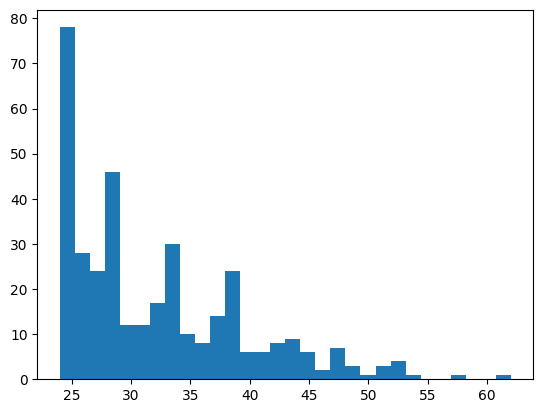

In [51]:
from matplotlib import pyplot as plt

plt.hist([len(e['error_frames']) for e in errors], bins=30)

In [42]:
# Play Video in Jupyter Notebook and sound plays at the same time
from IPython.display import Video

video_path = '/Users/azeez/Documents/pose_estimation/DanceToMusicApp/ml/data/samples/3sec_24fps_dnb/youtube_links_57_11_sample/youtube_links_57_11.mp4'
video_path = video_path.replace(".mp4", "_normalized_with_audio.mp4")
Video(video_path, embed=True, width=640, height=480)